## Launching

Using Spark 1.4 and Python 3.4. The way of launching the ipython notebook has changed

    IPYTHON=1 IPYTHON_OPTS=notebook PYSPARK_PYTHON=python3 pyspark

In [1]:
import os, sys

In [27]:
from pyspark.sql import SQLContext, Row
import datetime
from collections import namedtuple
import numpy as np
import pandas as pd

Create the SQLContext

In [3]:
sql = SQLContext(sc)

### Create different "classes" for parsing the rows

Ideally the rows would be parsed like this, but because custom row aggregation is not fully supported

In [5]:
RFScenario = namedtuple('RFScenario', ('rf', 'date', 'neutral', 'scenarios'))

and because the number of scenarios is fixed, each scenario is a column

In [6]:
def construct_scenarios_type(number_scenarios=250, name = 'Scenarios'):
    names = ['rf', 'date', 'neutral']
    scenario_cols = ["s%d"%x for x in range(1,number_scenarios+1)]
    names.extend(scenario_cols)
    Scenarios = namedtuple('Scenarios', names)
    return Scenarios, scenario_cols

Scenarios, scenario_cols = construct_scenarios_type()

and we can parse the rows of the csv file accordingly

In [30]:
DATA_DIR = os.path.join(os.pardir, 'data')
csv_filename = os.path.join(DATA_DIR, "scenarios2.csv")
pd.read_csv(csv_filename, header=None).head()


,0,1,2,3,4,5,6,7,8,9,...,243,244,245,246,247,248,249,250,251,252
0,RF1,2015-04-14,35.03,34.678659,35.193093,35.611624,34.920900,35.275753,34.885387,34.794800,...,35.445356,34.829611,35.514069,35.372834,35.343582,34.828644,34.824178,34.774605,34.879511,34.856106
1,RF1,2015-04-15,35.20,35.359100,35.767287,35.093559,35.439729,35.058909,34.970520,34.606949,...,35.004487,35.672156,35.534417,35.505887,35.003543,34.999186,34.950814,35.053176,35.030339,35.248848
2,RF1,2015-04-16,34.25,34.863274,34.135051,34.509031,34.097640,34.002225,33.610037,34.563266,...,34.760356,34.611395,34.580549,34.037870,34.033167,33.980956,34.091450,34.066796,34.302765,34.434559
3,RF1,2015-04-17,33.30,33.179576,33.571484,33.140390,33.040462,32.629955,33.628347,34.043960,...,33.678814,33.646469,33.077790,33.072865,33.018190,33.133906,33.108084,33.355289,33.493416,32.332506
4,RF1,2015-04-20,33.40,33.664591,33.244414,33.146995,32.746707,33.720002,34.124926,33.055073,...,33.737661,33.183387,33.178585,33.125281,33.238094,33.212921,33.453890,33.588511,32.456574,32.499345


In [31]:
from pyspark.mllib.linalg import Vectors, DenseVector, SparseVector, _convert_to_vector 
def parse(row):
    DATE_FMT = "%Y-%m-%d"
    row[0] = row[0]
    row[1] = datetime.datetime.strptime(row[1], DATE_FMT)
    for i in np.arange(2,len(row)):
        row[i] = float(row[i])
    return RFScenario(row[0], row[1], row[2], DenseVector(row[3:6]))


def parse_explicit(row):
    DATE_FMT = "%Y-%m-%d"
    row[0] = row[0]
    row[1] = datetime.datetime.strptime(row[1], DATE_FMT)
    for i in np.arange(2,len(row)):
        row[i] = float(row[i])
    return Scenarios(*row)

### Process the file in Spark

In [21]:
lines = sc.textFile(csv_filename)
parts = lines.map(lambda l: l.split(","))
rows = parts.map(parse)

In [22]:
rows_exp = parts.map(parse_explicit)
df_exp = sql.createDataFrame(rows_exp)

In [23]:
df_exp.head(1)

[Row(rf='RF1', date=datetime.datetime(2015, 4, 14, 0, 0), neutral=35.03, s1=34.67865912475935, s2=35.19309272805697, s3=35.61162381981636, s4=34.92090026310803, s5=35.2757534118607, s6=34.88538726175033, s7=34.7947997828024, s8=34.422262176432426, s9=35.32719209964416, s10=35.70279197608641, s11=34.70929644638722, s12=35.16468125943031, s13=34.7083308292015, s14=34.6909371576162, s15=34.24743006243561, s16=35.18043521116673, s17=35.26710783535421, s18=34.68646893255419, s19=35.42074885668956, s20=35.10073110319397, s21=34.62729258634153, s22=34.590238555794265, s23=35.12518904748294, s24=34.54164263329866, s25=34.780562034944296, s26=35.009313286776944, s27=35.19898478845906, s28=34.22306349493622, s29=35.58776307961069, s30=34.86817402539321, s31=34.904330793280025, s32=34.501576221982006, s33=34.908487404457446, s34=34.927195922549025, s35=35.26215239163238, s36=33.92269249584361, s37=34.30733618265355, s38=34.834677237655015, s39=34.62744354378543, s40=34.77382130417254, s41=34.7282

In [230]:
scenario_dates = df_exp.groupBy('date').sum()
var_rdd = scenario_dates.map(lambda r: (r[0], r[1], float(var(np.array(r[2:]) - r[1]))))
df_var = sql.createDataFrame(var_rdd, schema=['date', 'neutral', 'var'])

<IPython.core.display.Javascript object>


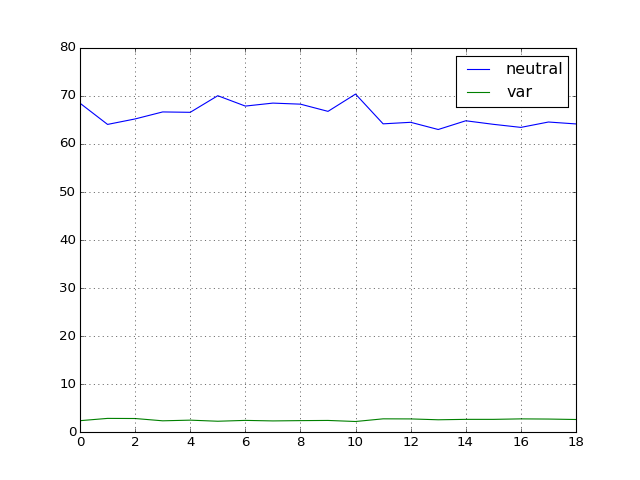

In [231]:
%matplotlib notebook
df_var.toPandas().plot()

In [236]:
pf_rdd = sc.parallelize([('P1', 'RF1', 1.), ('P1', 'RF2', 2.), ('P2', 'RF1', 0.2), ('P2', 'RF2', -0.8)])
dfpf = sqlContext.createDataFrame(pf_rdd, ['portfolio', 'rf', 'qty'])

In [237]:
dfpf.collect()

[Row(portfolio='P1', rf='RF1', qty=1.0),
 Row(portfolio='P1', rf='RF2', qty=2.0),
 Row(portfolio='P2', rf='RF1', qty=0.2),
 Row(portfolio='P2', rf='RF2', qty=-0.8)]

In [243]:
res = df_exp.join(dfpf, dfpf.rf == df_exp.rf)

In [249]:
res.selectExpr(*df_exp.columns)

Py4JJavaError: An error occurred while calling o2050.selectExpr.
: org.apache.spark.sql.AnalysisException: Reference 'rf' is ambiguous, could be: rf#33286, rf#35052.;
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.resolve(LogicalPlan.scala:279)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.resolveChildren(LogicalPlan.scala:116)
	at org.apache.spark.sql.catalyst.analysis.Analyzer$ResolveReferences$$anonfun$apply$8$$anonfun$applyOrElse$4$$anonfun$16.apply(Analyzer.scala:350)
	at org.apache.spark.sql.catalyst.analysis.Analyzer$ResolveReferences$$anonfun$apply$8$$anonfun$applyOrElse$4$$anonfun$16.apply(Analyzer.scala:350)
	at org.apache.spark.sql.catalyst.analysis.package$.withPosition(package.scala:48)
	at org.apache.spark.sql.catalyst.analysis.Analyzer$ResolveReferences$$anonfun$apply$8$$anonfun$applyOrElse$4.applyOrElse(Analyzer.scala:350)
	at org.apache.spark.sql.catalyst.analysis.Analyzer$ResolveReferences$$anonfun$apply$8$$anonfun$applyOrElse$4.applyOrElse(Analyzer.scala:341)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformUp$1.apply(TreeNode.scala:286)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformUp$1.apply(TreeNode.scala:286)
	at org.apache.spark.sql.catalyst.trees.CurrentOrigin$.withOrigin(TreeNode.scala:51)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformUp(TreeNode.scala:285)
	at org.apache.spark.sql.catalyst.plans.QueryPlan.org$apache$spark$sql$catalyst$plans$QueryPlan$$transformExpressionUp$1(QueryPlan.scala:108)
	at org.apache.spark.sql.catalyst.plans.QueryPlan$$anonfun$2$$anonfun$apply$2.apply(QueryPlan.scala:123)
	at scala.collection.TraversableLike$$anonfun$map$1.apply(TraversableLike.scala:244)
	at scala.collection.TraversableLike$$anonfun$map$1.apply(TraversableLike.scala:244)
	at scala.collection.immutable.List.foreach(List.scala:318)
	at scala.collection.TraversableLike$class.map(TraversableLike.scala:244)
	at scala.collection.AbstractTraversable.map(Traversable.scala:105)
	at org.apache.spark.sql.catalyst.plans.QueryPlan$$anonfun$2.apply(QueryPlan.scala:122)
	at scala.collection.Iterator$$anon$11.next(Iterator.scala:328)
	at scala.collection.Iterator$class.foreach(Iterator.scala:727)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1157)
	at scala.collection.generic.Growable$class.$plus$plus$eq(Growable.scala:48)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:103)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:47)
	at scala.collection.TraversableOnce$class.to(TraversableOnce.scala:273)
	at scala.collection.AbstractIterator.to(Iterator.scala:1157)
	at scala.collection.TraversableOnce$class.toBuffer(TraversableOnce.scala:265)
	at scala.collection.AbstractIterator.toBuffer(Iterator.scala:1157)
	at scala.collection.TraversableOnce$class.toArray(TraversableOnce.scala:252)
	at scala.collection.AbstractIterator.toArray(Iterator.scala:1157)
	at org.apache.spark.sql.catalyst.plans.QueryPlan.transformExpressionsUp(QueryPlan.scala:127)
	at org.apache.spark.sql.catalyst.analysis.Analyzer$ResolveReferences$$anonfun$apply$8.applyOrElse(Analyzer.scala:341)
	at org.apache.spark.sql.catalyst.analysis.Analyzer$ResolveReferences$$anonfun$apply$8.applyOrElse(Analyzer.scala:243)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformUp$1.apply(TreeNode.scala:286)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformUp$1.apply(TreeNode.scala:286)
	at org.apache.spark.sql.catalyst.trees.CurrentOrigin$.withOrigin(TreeNode.scala:51)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformUp(TreeNode.scala:285)
	at org.apache.spark.sql.catalyst.analysis.Analyzer$ResolveReferences$.apply(Analyzer.scala:243)
	at org.apache.spark.sql.catalyst.analysis.Analyzer$ResolveReferences$.apply(Analyzer.scala:242)
	at org.apache.spark.sql.catalyst.rules.RuleExecutor$$anonfun$execute$1$$anonfun$apply$1.apply(RuleExecutor.scala:61)
	at org.apache.spark.sql.catalyst.rules.RuleExecutor$$anonfun$execute$1$$anonfun$apply$1.apply(RuleExecutor.scala:59)
	at scala.collection.LinearSeqOptimized$class.foldLeft(LinearSeqOptimized.scala:111)
	at scala.collection.immutable.List.foldLeft(List.scala:84)
	at org.apache.spark.sql.catalyst.rules.RuleExecutor$$anonfun$execute$1.apply(RuleExecutor.scala:59)
	at org.apache.spark.sql.catalyst.rules.RuleExecutor$$anonfun$execute$1.apply(RuleExecutor.scala:51)
	at scala.collection.immutable.List.foreach(List.scala:318)
	at org.apache.spark.sql.catalyst.rules.RuleExecutor.execute(RuleExecutor.scala:51)
	at org.apache.spark.sql.SQLContext$QueryExecution.analyzed$lzycompute(SQLContext.scala:922)
	at org.apache.spark.sql.SQLContext$QueryExecution.analyzed(SQLContext.scala:922)
	at org.apache.spark.sql.SQLContext$QueryExecution.assertAnalyzed(SQLContext.scala:920)
	at org.apache.spark.sql.DataFrame.<init>(DataFrame.scala:131)
	at org.apache.spark.sql.DataFrame.org$apache$spark$sql$DataFrame$$logicalPlanToDataFrame(DataFrame.scala:154)
	at org.apache.spark.sql.DataFrame.select(DataFrame.scala:595)
	at org.apache.spark.sql.DataFrame.selectExpr(DataFrame.scala:625)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:57)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:606)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:231)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:379)
	at py4j.Gateway.invoke(Gateway.java:259)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:133)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:207)
	at java.lang.Thread.run(Thread.java:744)


In [122]:
f = sql.udf.register("fadd", lambda x: (np.array(x[3]) * 3.1).tolist(), ArrayType(FloatType()))
fagg = sql.udf.register("fagg", lambda x,y: (np.array(x[3]) + np.array(y[3])).tolist(), ArrayType(FloatType()))

In [76]:
sql.registerDataFrameAsTable(df, 'scen')

In [128]:
sql.sql('select date, fadd(scenarios) from scen group by date').collect()

Py4JJavaError: An error occurred while calling o111.sql.
: org.apache.spark.sql.AnalysisException: expression 'pythonUDF' is neither present in the group by, nor is it an aggregate function. Add to group by or wrap in first() if you don't care which value you get.;
	at org.apache.spark.sql.catalyst.analysis.CheckAnalysis$class.failAnalysis(CheckAnalysis.scala:38)
	at org.apache.spark.sql.catalyst.analysis.Analyzer.failAnalysis(Analyzer.scala:42)
	at org.apache.spark.sql.catalyst.analysis.CheckAnalysis$$anonfun$checkAnalysis$1.org$apache$spark$sql$catalyst$analysis$CheckAnalysis$class$$anonfun$$checkValidAggregateExpression$1(CheckAnalysis.scala:95)
	at org.apache.spark.sql.catalyst.analysis.CheckAnalysis$$anonfun$checkAnalysis$1$$anonfun$apply$4.apply(CheckAnalysis.scala:111)
	at org.apache.spark.sql.catalyst.analysis.CheckAnalysis$$anonfun$checkAnalysis$1$$anonfun$apply$4.apply(CheckAnalysis.scala:111)
	at scala.collection.immutable.List.foreach(List.scala:318)
	at org.apache.spark.sql.catalyst.analysis.CheckAnalysis$$anonfun$checkAnalysis$1.apply(CheckAnalysis.scala:111)
	at org.apache.spark.sql.catalyst.analysis.CheckAnalysis$$anonfun$checkAnalysis$1.apply(CheckAnalysis.scala:50)
	at org.apache.spark.sql.catalyst.trees.TreeNode.foreachUp(TreeNode.scala:98)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$foreachUp$1.apply(TreeNode.scala:97)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$foreachUp$1.apply(TreeNode.scala:97)
	at scala.collection.immutable.List.foreach(List.scala:318)
	at org.apache.spark.sql.catalyst.trees.TreeNode.foreachUp(TreeNode.scala:97)
	at org.apache.spark.sql.catalyst.analysis.CheckAnalysis$class.checkAnalysis(CheckAnalysis.scala:50)
	at org.apache.spark.sql.catalyst.analysis.Analyzer.checkAnalysis(Analyzer.scala:42)
	at org.apache.spark.sql.SQLContext$QueryExecution.assertAnalyzed(SQLContext.scala:920)
	at org.apache.spark.sql.DataFrame.<init>(DataFrame.scala:131)
	at org.apache.spark.sql.DataFrame$.apply(DataFrame.scala:51)
	at org.apache.spark.sql.SQLContext.sql(SQLContext.scala:744)
	at sun.reflect.GeneratedMethodAccessor53.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:606)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:231)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:379)
	at py4j.Gateway.invoke(Gateway.java:259)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:133)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:207)
	at java.lang.Thread.run(Thread.java:744)


In [206]:
def var(scenarios, level=99, neutral_scenario=0):
    pnls = scenarios - neutral_scenario
    return - np.percentile(pnls, 100-level, interpolation='linear')